In [2]:
# Dépendances
import numpy as np
import random as rd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="hls", font="sans-serif", font_scale=1.4)
from tqdm import tqdm_notebook as tqdm


In [3]:
def simulation(bras, algorithme, horizon):
    """ Simule l'algorithme donné sur ces bras, durant horizon étapes."""
    choix, recompenses = np.zeros(horizon), np.zeros(horizon)
    # 1. Initialise l'algorithme
    algorithme.commence()
    # 2. Boucle en temps, pour t = 0 à horizon - 1
    for t in range(horizon):
        # 2.a. L'algorithme choisi son bras à essayer
        A_t = algorithme.choix()
        # 2.b. Le bras k donne une récompense
        r_k_t = bras[A_t].tire()
        # 2.c. La récompense est donnée à l'algorithme
        algorithme.recompense(A_t, r_k_t)
        # 2.d. On stocke les deux
        choix[t] = A_t
        recompenses[t] = r_k_t
    # 3. On termine en renvoyant ces deux vecteurs
    return recompenses, choix


In [4]:
class Bernoulli():
    """ Bras distribués selon une loi de Bernoulli."""

    def __init__(self, probabilite):
        assert 0 <= probabilite <= 1, "Erreur, probabilite doit être entre 0 et 1 pour un bras de Bernoulli."
        self.probabilite = probabilite

    def tire(self):
        """ Tire une récompense aléatoire."""
        return float(rd.random() <= self.probabilite)


In [5]:
class ChoixUniforme(object):
    """Algorithme stupide, choix uniforme."""
    
    def __init__(self, K):
        """Crée l'instance de l'algorithme."""
        self.K = K
    
    def commence(self):
        """Initialise l'algorithme : rien à faire ici."""
        pass
    
    def choix(self):
        """Choix uniforme d'un indice A(t) ~ U(1...K)."""
        return rd.randint(0, self.K - 1)
        
    def recompense(self, k, r):
        """Donne une récompense r tirée sur le bras k à l'algorithme : rien à faire ici."""
        pass


In [6]:
class MoyenneEmpirique(object):
    """Algorithme naïf, qui utilise la moyenne empirique."""
    
    def __init__(self, K):
        """Crée l'instance de l'algorithme."""
        self.K = K
        # Il nous faut de la mémoire interne
        self.recompenses = np.zeros(K)  # X_k(t) pour chaque k
        self.tirages = np.zeros(K)      # N_k(t) pour chaque k
        self.t = 0                      # Temps t interne
    
    def commence(self):
        """Initialise l'algorithme : remet à zeros chaque X_k et N_k, et t = 0."""
        self.recompenses.fill(0)
        self.tirages.fill(0)
        self.t = 0
    
    def choix(self):
        """Si on a vu tous les bras, on prend celui de moyenne empirique la plus grande."""
        # 1er cas : il y a encore des bras qu'on a jamais vu
        if np.min(self.tirages) == 0:
            k = np.min(np.where(self.tirages == 0)[0])
        # 2nd cas : tous les bras ont été essayé
        else:
            # Notez qu'on aurait pu ne stocker que ce vecteur moyennes_empiriques
            moyennes_empiriques = self.recompenses / self.tirages
            k = np.argmax(moyennes_empiriques)
        self.t += 1      # Inutile ici
        return k
        
    def recompense(self, k, r):
        """Donne une récompense r tirée sur le bras k à l'algorithme : met à jour les deux vecteurs internes."""
        self.recompenses[k] += r
        self.tirages[k] += 1


In [7]:
class UCB1(MoyenneEmpirique):
    """Algorithme UCB1."""
    
    def __init__(self, K, alpha=1):
        """Crée l'instance de l'algorithme. Par défaut, alpha=1."""
        super(UCB1, self).__init__(K)  # On laisse la classe mère faire le travaille
        assert alpha >= 0, "Erreur : alpha doit etre >= 0."
        self.alpha = alpha
    
    def choix(self):
        """Si on a vu tous les bras, on prend celui d'indice moyenne empirique + UCB le plus grand."""
        self.t += 1      # Nécessaire ici
        # 1er cas : il y a encore des bras qu'on a jamais vu
        if np.min(self.tirages) == 0:
            k = np.min(np.where(self.tirages == 0)[0])
        # 2nd cas : tous les bras ont été essayé
        else:
            moyennes_empiriques = self.recompenses / self.tirages
            ucb = np.sqrt(self.alpha * np.log(self.t) / self.tirages)
            indices = moyennes_empiriques + ucb
            k = np.argmax(indices)
        return k

In [8]:
mpl.rcParams['figure.figsize'] = (15, 8)

In [74]:
def affiche_selections(choix, noms, kstar=0):
    print(enumerate(choix))
    plt.figure()

    for i, c in enumerate(choix):
        selection_kstar = 1.0 * (c == kstar)
        selection_moyenne = np.cumsum(selection_kstar) / np.cumsum(np.ones_like(c))
        print("kstar",selection_kstar)
        print("moyenne",selection_moyenne)
        plt.plot(selection_moyenne, label=noms[i])
    plt.legend()
    plt.xlabel("Temps discret, $t = 1, ..., T = {}$".format(len(choix[0])))
    plt.ylabel("Taux de sélection")
    plt.title("Sélection du meilleur bras #{} pour différents algorithmes".format(1 + kstar))
    plt.show()

def affiche_recompenses(recompenses, noms):
    plt.figure()
    for i, r in enumerate(recompenses):
        recompense_accumulee = np.cumsum(r)
        plt.plot(recompense_accumulee, label=noms[i])
    plt.legend()
    plt.xlabel("Temps discret, $t = 1, ..., T = {}$".format(len(recompenses[0])))
    plt.ylabel("Récompenses accumulées")
    plt.title("Récompenses accumulées pour différents algorithmes")
    plt.show()

def affiche_recompenses_moyennes(recompenses, noms):
    plt.figure()
    for i, r in enumerate(recompenses):
        recompense_moyenne = np.cumsum(r) / np.cumsum(np.ones_like(r))
        plt.plot(recompense_moyenne, label=noms[i])
    plt.legend()
    plt.xlabel("Temps discret, $t = 1, ..., T = {}$".format(len(recompenses[0])))
    plt.ylabel(r"Récompenses moyennes $\in [0, 1]$")
    plt.title("Récompenses moyennes pour différents algorithmes")
    plt.show()

def affiche_regret(recompenses, noms, mustar=1):
    plt.figure()
    for i, r in enumerate(recompenses):
        recompense_accumulee = np.cumsum(r)
        regret = mustar * np.cumsum(np.ones_like(r)) - recompense_accumulee
        plt.plot(regret, label=noms[i])
    plt.legend()
    plt.xlabel("Temps discret, $t = 1, ..., T = {}$".format(len(recompenses[0])))
    plt.ylabel("Regret")
    plt.title("Regret accumulé pour différents algorithmes")
    plt.show()

def nrows_ncols(N):
    """(nrows, ncols) pour créer un subplots de N figures avec les bonnes dimensions."""
    nrows = int(np.ceil(np.sqrt(N)))
    ncols = N // nrows
    while N > nrows * ncols:
        ncols += 1
    nrows, ncols = max(nrows, ncols), min(nrows, ncols)
    return nrows, ncols


def affiche_hist_regret(recompenses, noms, horizon, mustar=1):
    nrows, ncols = nrows_ncols(len(noms))
    fig, axes = plt.subplots(nrows, ncols, sharex=False, sharey=False)
    fig.suptitle("Histogramme du regret à $t = T = {}$ pour différents algorithmes".format(len(choix[0])))

    # XXX See https://stackoverflow.com/a/36542971/
    ax0 = fig.add_subplot(111, frame_on=False)  # add a big axes, hide frame
    ax0.grid(False)  # hide grid
    ax0.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')  # hide tick and tick label of the big axes
    # Add only once the ylabel, xlabel, in the middle
    ax0.set_ylabel("Distribution")
    ax0.set_xlabel("Regret")

    for i, r in enumerate(recompenses):
        x, y = i % nrows, i // nrows
        ax = axes[x, y] if ncols > 1 else axes[x]
        regret = mustar * horizon - r
        ax.hist(regret, normed=True, bins=25)
        ax.set_title(noms[i])
    plt.show()



In [75]:
horizon = 1000
mus = [0.9, 0.5, 0.1]
bras = [ Bernoulli(mu) for mu in mus ]
K = len(mus)
kstar = np.argmax(mus)  # = 0

In [76]:
algorithmes = [ChoixUniforme(K), MoyenneEmpirique(K),
               UCB1(K, alpha=1)]
algorithmes


In [77]:
noms = ["ChoixUniforme", "MoyenneEmpirique",
        "UCB1(alpha=1)"]

In [78]:
%%time
N = len(algorithmes)
recompenses, choix = np.zeros((N, horizon)), np.zeros((N, horizon))

for i, alg in tqdm(enumerate(algorithmes), desc="Algorithmes"):
    rec, ch = simulation(bras, alg, horizon)
    recompenses[i] = rec
    choix[i] = ch
    print(len(ch))

<timed exec>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Algorithmes: 0it [00:00, ?it/s]

1000
1000
1000
CPU times: user 70.7 ms, sys: 14.9 ms, total: 85.6 ms
Wall time: 73.2 ms


kstar [1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.

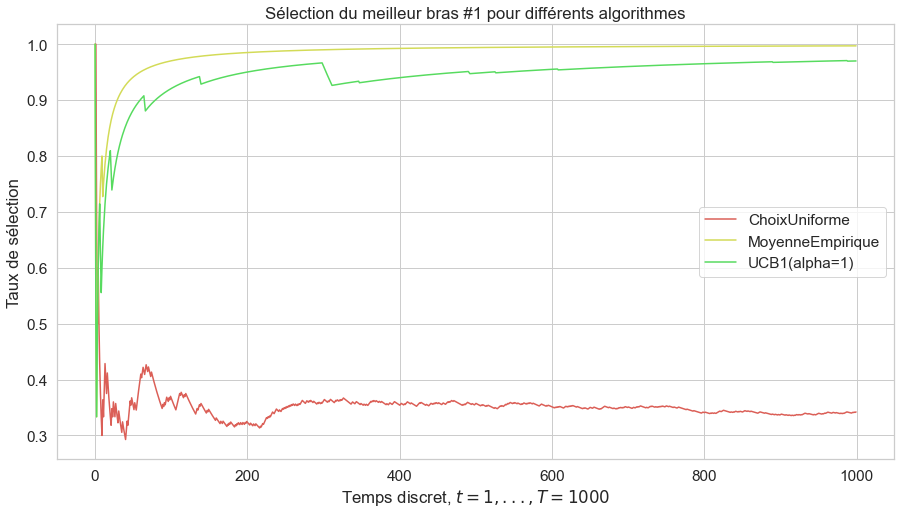

In [79]:
affiche_selections(choix, noms, kstar)

In [38]:
for i in range(10) : 
  i = 1
  i_pt = np.cumsum(i)

i_pt

array([1])

In [2]:
choix = "UCB-0.5"
choix[0:3]

'UCB'